In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from string import punctuation
import numpy as np
import json
import re

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Loading JSON data
with open('./emotion_id_tweets.json', 'r') as f_obj:
    tweets_data = [json.loads(line) for line in f_obj]

In [3]:
tweets_data[0]

{'content': '@04Nakula @jokowi @prabowo @Gerindra @DailymotionUSA pdhl poros ke3 ini sebenarnya mau nelikung koalisi dr @prabowo…',
 'annotation': {'labels': ['joy'], 'note': ''},
 'extras': None,
 'metadata': {'first_done_at': 1527710555000,
  'last_updated_at': 1527710555000,
  'sec_taken': 6,
  'last_updated_by': 'a31puKbtO4fdTOgO7YPfppu3GR52',
  'status': 'done',
  'evaluation': 'NONE'}}

In [4]:
len(tweets_data)

8682

In [5]:
# Converting the json data to pandas dataframe
tweets_df = pd.DataFrame(tweets_data)

In [6]:
tweets_df['extras'].unique()

array([None], dtype=object)

In [7]:
from pandas.io.json import json_normalize

In [8]:
tweets_df_norm = json_normalize(tweets_data)

In [9]:
tweets_df_norm.head()

,annotation.labels,annotation.note,content,extras,metadata.evaluation,metadata.first_done_at,metadata.last_updated_at,metadata.last_updated_by,metadata.sec_taken,metadata.status
0,[joy],,@04Nakula @jokowi @prabowo @Gerindra @Dailymot...,None,NONE,1527710555000,1527710555000,a31puKbtO4fdTOgO7YPfppu3GR52,6,done
1,[joy],,@Achmadr06327297 @fadlizon @Gerindra @prabowo ...,None,NONE,1527984453000,1527984453000,a31puKbtO4fdTOgO7YPfppu3GR52,93,done
2,[fear],,@Gerindra @PKSejahtera @prabowo Seandainya sek...,None,NONE,1528396641000,1528396641000,a31puKbtO4fdTOgO7YPfppu3GR52,9,done
3,[joy],,@fadlizon @Gerindra @prabowo Saya dukung pak p...,None,NONE,1527988971000,1527988971000,a31puKbtO4fdTOgO7YPfppu3GR52,7,done
4,[trust],,@Gerindra @PKSejahtera Mencari yang setia dan ...,None,NONE,1528445338000,1528445338000,a31puKbtO4fdTOgO7YPfppu3GR52,7,done


In [10]:
tweets_df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8682 entries, 0 to 8681
Data columns (total 10 columns):
annotation.labels           8682 non-null object
annotation.note             8682 non-null object
content                     8682 non-null object
extras                      0 non-null object
metadata.evaluation         8682 non-null object
metadata.first_done_at      8682 non-null int64
metadata.last_updated_at    8682 non-null int64
metadata.last_updated_by    8682 non-null object
metadata.sec_taken          8682 non-null int64
metadata.status             8682 non-null object
dtypes: int64(3), object(7)
memory usage: 678.4+ KB


In [11]:
tweets_df_norm['annotation.note'].value_counts()

          8669
kosong       7
Kosong       6
Name: annotation.note, dtype: int64

In [12]:
tweets_df_norm['extras'].unique()

array([None], dtype=object)

In [13]:
tweets_df_norm['metadata.evaluation'].unique()

array(['NONE'], dtype=object)

In [14]:
tweets_df_norm['metadata.last_updated_by'].unique()

array(['a31puKbtO4fdTOgO7YPfppu3GR52'], dtype=object)

In [15]:
tweets_df_norm['metadata.status'].unique()

array(['done'], dtype=object)

In [16]:
tweets_df_norm['annotation.labels'] = tweets_df_norm['annotation.labels'].apply(lambda x: x[0] if len(x) > 0 else 'other')

In [17]:
tweets_df_norm['annotation.labels'].value_counts()

joy             2327
trust           1879
anticipation    1457
anger            996
sadness          738
fear             624
disgust          554
surprise          92
other             15
Name: annotation.labels, dtype: int64

#### Based on the above analysis, we found that, 
* "note", "evaluation", "last_updated_by", "status" are redundant columns, so we'll remove these columns. 
* Since not much info is available about "first_done_at", "last_updated_at" and "sec_taken". So we'll remove these as well from our analysis
* Regarding labels, there are 15 rows whose value is empty string, these values have been replaced by "others" category

In [18]:
# Checking if 'metadata.first_done_at' and 'metadata.last_updated_at' have same values
tweets_df_norm['metadata.first_done_at'].equals(tweets_df_norm['metadata.last_updated_at'])

True

In [19]:
unwanted_columns = ['annotation.note', 'extras', 'metadata.evaluation', 'metadata.status', 'metadata.first_done_at',
                    'metadata.last_updated_at', 'metadata.last_updated_by', 'metadata.last_updated_by', 'metadata.sec_taken']
tweets_df_norm.drop(unwanted_columns, axis=1, inplace=True)

In [20]:
tweets_df_norm.head()

,annotation.labels,content
0,joy,@04Nakula @jokowi @prabowo @Gerindra @Dailymot...
1,joy,@Achmadr06327297 @fadlizon @Gerindra @prabowo ...
2,fear,@Gerindra @PKSejahtera @prabowo Seandainya sek...
3,joy,@fadlizon @Gerindra @prabowo Saya dukung pak p...
4,trust,@Gerindra @PKSejahtera Mencari yang setia dan ...


In [21]:
# Cleaning the tweets, removing punctuations and special characters and lowercasing

# Removing '#' and '@' from the list of punctuations( we need to extract hashtags and mentions)
punctuation = punctuation.replace('#', '').replace('@', '')

# Found this character in thw data which is different from period character
punctuation = punctuation + '…'

def process_tweet(tweet):
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    tweet = tweet.lower()
    for char in tweet:
        if char in punctuation:
            tweet = tweet.replace(char, '')
    tweet = tweet.replace('\\n', '')
    tweet = ''.join(word for word in tweet if not word.isdigit())
    
    return tweet


tweets_df_norm['cleaned_content'] = tweets_df_norm['content'].apply(lambda x: process_tweet(x))

In [22]:
# Check for NaNs

tweets_df_norm.isnull().sum()

annotation.labels    0
content              0
cleaned_content      0
dtype: int64

In [23]:
# Word count per tweet
tweets_df_norm['word_count'] = tweets_df_norm['cleaned_content'].apply(lambda x: len(x.split()))
tweets_df_norm.head()

,annotation.labels,content,cleaned_content,word_count
0,joy,@04Nakula @jokowi @prabowo @Gerindra @Dailymot...,@nakula @jokowi @prabowo @gerindra @dailymotio...,15
1,joy,@Achmadr06327297 @fadlizon @Gerindra @prabowo ...,@achmadr @fadlizon @gerindra @prabowo maap bos...,14
2,fear,@Gerindra @PKSejahtera @prabowo Seandainya sek...,@gerindra @pksejahtera @prabowo seandainya sek...,18
3,joy,@fadlizon @Gerindra @prabowo Saya dukung pak p...,@fadlizon @gerindra @prabowo saya dukung pak p...,10
4,trust,@Gerindra @PKSejahtera Mencari yang setia dan ...,@gerindra @pksejahtera mencari yang setia dan ...,16


In [24]:
tweets_df_norm['word_count'].describe()

count    8682.000000
mean       18.117139
std        26.196650
min         0.000000
25%         9.000000
50%        14.000000
75%        18.000000
max       725.000000
Name: word_count, dtype: float64

In [25]:
# Removing empty tweets
tweets_df_norm = tweets_df_norm[tweets_df_norm['cleaned_content'] != '']

### Finding if there are any duplicate tweets

In [26]:
tweets_df_norm.duplicated(subset='cleaned_content').sum()

2245

In [27]:
tweets_df_norm.duplicated(subset=['cleaned_content', 'annotation.labels']).sum()

1620

> The difference in above two means, there are same tweets but with different labels. One of the example is:
> * 'setya novanto menghilang pengacara ada tugas negara sangat urgen' -> 'anticipation'
> * 'setya novanto menghilang pengacara ada tugas negara sangat urgen' -> 'trust'

> We removed the duplicates based on the tweets and for those duplicate tweets which had different labels, we kept the first occurrence and dropped the rest

In [28]:
# De-duplicated tweets data based on the cleaned_content
content_dedup_df = tweets_df_norm.drop_duplicates(['cleaned_content'])

In [29]:
# To check if there are any duplicates across the dataframe
content_dedup_df.duplicated().sum()

0

### Word Count distribution and analysis based on the words, hastags and mentions

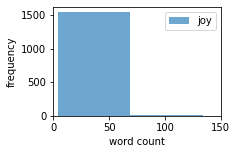

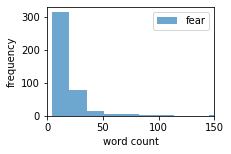

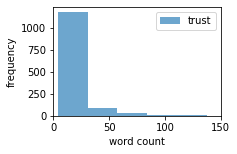

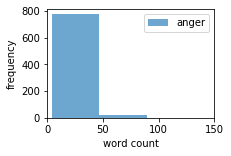

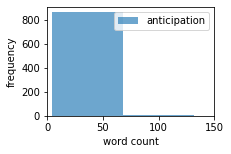

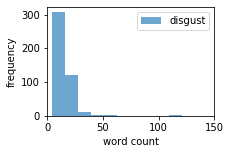

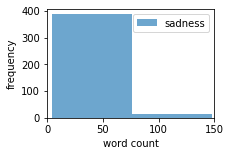

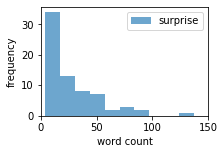

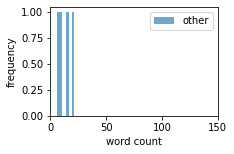

In [65]:
labels = content_dedup_df['annotation.labels'].unique()
label_dist_list = [content_dedup_df['word_count'][content_dedup_df['annotation.labels'] == label] \
                                                  for label in labels]
for i,label in enumerate(labels):
    plt.figure(figsize=(3,2))
    plt.xlim(0,150)
    plt.xlabel('word count')
    plt.ylabel('frequency')
    g = plt.hist(label_dist_list[i], alpha=0.65, label=label)
    plt.legend(loc='upper right')
    plt.savefig(f"./test_{i}.png")


In [31]:
# Most common words in the data
words = []

for _, row in content_dedup_df.iterrows():
    tweet = row['cleaned_content']
    tweet = tweet.split()
    for word in tweet:
        words.append(word)
        
Counter(words).most_common(20)

[('di', 1900),
 ('dan', 1627),
 ('yang', 1293),
 ('yg', 1223),
 ('saya', 1086),
 ('ini', 884),
 ('@gerindra', 787),
 ('@prabowo', 776),
 ('ada', 710),
 ('untuk', 708),
 ('bisa', 607),
 ('itu', 554),
 ('tidak', 553),
 ('dari', 524),
 ('pak', 521),
 ('dengan', 493),
 ('kita', 439),
 ('@fadlizon', 418),
 ('ke', 390),
 ('ya', 388)]

In [32]:
# Extracting hashtags and mentions
hashtags = []
mentions = []

for _, row in content_dedup_df.iterrows():
    tweet = row['cleaned_content']
    try:
        temp_hashtags = re.findall(r"#(\w+)", tweet)
        temp_mentions = re.findall(r"@(\w+)", tweet)
    except TypeError:
        print(tweet)
        break
        

    hashtagger = lambda x: "#" + x
    mentioner = lambda x: "@" + x
    temp_hashtags = list(map(hashtagger, temp_hashtags))
    temp_mentions = list(map(mentioner, temp_mentions))
    hashtags.extend(temp_hashtags)
    mentions.extend(temp_mentions)
            


In [33]:
print("Top 20 most common hashtags:-")
Counter(hashtags).most_common(20)

Top 20 most common hashtags:-


[('#gantipresiden', 60),
 ('#rindujabarjuara', 30),
 ('#ichoosehappy', 26),
 ('#rindu', 17),
 ('#wirelessbylogitech', 16),
 ('#pastiequity', 15),
 ('#equitylifeindonesia', 15),
 ('#sedulurngaji', 14),
 ('#ramadhan', 14),
 ('#jjonlne', 13),
 ('#puasa', 12),
 ('#autoprotection', 12),
 ('#kamiganjaryasin', 11),
 ('#romahurmuziy', 11),
 ('#lippoinsurance', 11),
 ('#lgi', 11),
 ('#cashplus', 11),
 ('#healthinsurance', 11),
 ('#myhealthduo', 11),
 ('#sgap', 11)]

In [34]:
print("Top 20 most common mentions:-")
Counter(mentions).most_common(20)

Top 20 most common mentions:-


[('@gerindra', 794),
 ('@prabowo', 783),
 ('@fadlizon', 423),
 ('@jokowi', 344),
 ('@sbyudhoyono', 243),
 ('@mromahurmuziy', 241),
 ('@pksejahtera', 233),
 ('@ganjarpranowo', 175),
 ('@cakiminow', 138),
 ('@ridwankamil', 118),
 ('@yusrilihzamhd', 94),
 ('@sudirmansaid', 93),
 ('@pbb', 80),
 ('@dprri', 71),
 ('@officialpan', 65),
 ('@mardanialisera', 59),
 ('@psiid', 59),
 ('@detikcom', 58),
 ('@zulhasan', 57),
 ('@msisohibuliman', 49)]

### Preparing data for classification task

In [35]:
## Removing hashtags and mentions from the text for modelling purpose

def remove_ht_mt(tweet):
    tweet = re.sub(r"#(\w+)", '', tweet)
    tweet = re.sub(r"@(\w+)", '', tweet)
    return tweet

content_dedup_df['final_cleaned_content'] = content_dedup_df['cleaned_content'].apply(lambda x: remove_ht_mt(x))

/Users/abhayana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
content_dedup_df['final_word_count'] = content_dedup_df['final_cleaned_content'].apply(lambda x: len(x.split()))

/Users/abhayana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
content_dedup_df['final_word_count'].describe()

count    6435.000000
mean       15.265113
std        25.877848
min         0.000000
25%         7.000000
50%        11.000000
75%        16.000000
max       725.000000
Name: final_word_count, dtype: float64

In [38]:
# Taking those tweets having atleast 4 words
content_dedup_df = content_dedup_df[content_dedup_df['final_word_count'] > 3]

In [39]:
content_dedup_df['final_word_count'].describe()

count    5938.000000
mean       16.356517
std        26.650358
min         4.000000
25%         8.000000
50%        12.000000
75%        16.000000
max       725.000000
Name: final_word_count, dtype: float64

In [40]:
content_dedup_df.duplicated(subset='final_cleaned_content').sum()

31

> The duplicates have been found after removing hashtags and mentions from the tweet contents. This is possible because although the tweet content was similar but either hastags or mentions were different. For example:
> * 'berkomitmen melestarikan desa adat emil dardak didoakan pemangku adat pacet #jatimsiji'
> * 'berkomitmen melestarikan desa adat emil dardak didoakan pemangku adat pacet #kabehsedulur'


In [41]:
# Removing duplicated tweets
content_dedup_df.drop_duplicates(subset='final_cleaned_content', inplace=True)

In [42]:
content_dedup_df.shape

(5907, 6)

In [43]:
content_dedup_df.head()

,annotation.labels,content,cleaned_content,word_count,final_cleaned_content,final_word_count
0,joy,@04Nakula @jokowi @prabowo @Gerindra @Dailymot...,@nakula @jokowi @prabowo @gerindra @dailymotio...,15,pdhl poros ke ini sebenarnya mau nelikung...,9
1,joy,@Achmadr06327297 @fadlizon @Gerindra @prabowo ...,@achmadr @fadlizon @gerindra @prabowo maap bos...,14,maap bosmending ngomong realita aja soal k...,10
2,fear,@Gerindra @PKSejahtera @prabowo Seandainya sek...,@gerindra @pksejahtera @prabowo seandainya sek...,18,seandainya sekutu berpaling apa masih tetap...,15
3,joy,@fadlizon @Gerindra @prabowo Saya dukung pak p...,@fadlizon @gerindra @prabowo saya dukung pak p...,10,saya dukung pak prabowo capresnamun plihan,6
4,trust,@Gerindra @PKSejahtera Mencari yang setia dan ...,@gerindra @pksejahtera mencari yang setia dan ...,16,mencari yang setia dan sepemikiran itu sulit...,14


In [48]:
#Avg word count by category

avg_wc = content_dedup_df.groupby('annotation.labels').median().reset_index()
avg_wc[['annotation.labels', 'final_word_count']]

,annotation.labels,final_word_count
0,anger,12.0
1,anticipation,10.0
2,disgust,10.0
3,fear,14.0
4,joy,11.0
5,other,10.5
6,sadness,15.0
7,surprise,17.5
8,trust,12.0


In [45]:
content_dedup_df[['final_cleaned_content', 'annotation.labels']].to_csv("./cleaned_tweets.csv", index=False)